### Introduction

While working with semantic search, I encountered a problem with defining the acceptance threshold for my findings. This problem becomes significant when the texts being compared are of significantly different lengths and/or contain significantly different degrees of content. In other words, the problem becomes serious when we deal with the so-called asymmetrical _semantic search_ 
(https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search).

In the following, I would like to share a method which allows to dynamically determine the ___acceptance threshold___ _of found pairs_ . This method may determine the final solution or be a prelude to a more modified version. 

As an experiment I will use reuters data, known as reuters-21578 
(https://paperswithcode.com/dataset/reuters-21578).<br>

In [1]:
%config Completer.use_jedi = False

### Download the Reuters data:

In [2]:
from nltk.corpus import reuters
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/bogdan/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

### import requested libraries

In [3]:
import re
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 600)
from kneed import KneeLocator

import matplotlib.pyplot as plt
import matplotlib

### definitions of custom functions 

In [4]:
# functions:
#
def removal_signs(sentence):
    # replace signs by whitespace:
    custom_punctuation='!"$%&\'()*-/;=@[\\]^_`{|}~’”…•●'
    table = str.maketrans(custom_punctuation,' '*30) # official set of punctuation 
    sentence = sentence.translate(table)
    # remove multiplicated whitespaces: 
    sentence = re.sub('\s+', ' ', sentence)
    return sentence

### reading documents 
based on: https://raw.githubusercontent.com/miguelmalvarez/reuters-tc/master/Classification_Reuters.ipynb

In [5]:
documents = reuters.fileids()
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))

### available categories of texts

In [6]:
reuters.categories()

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

### Preprocessing of the Reuter's texts

In [7]:
train_docs = [ removal_signs(item_.replace('\n','').strip()) for item_ in [reuters.raw(doc_id) for doc_id in train_docs_id]]
test_docs = [ removal_signs(item_.replace('\n','').strip()) for item_ in [reuters.raw(doc_id) for doc_id in test_docs_id]]

# remove sentences with only capital letters:
sl = re.compile('[a-z]+')
train_docs = [ item_ for item_ in train_docs if len(sl.findall(item_))>0]
test_docs = [ item_ for item_ in test_docs if len(sl.findall(item_))>0]

# remove duplicates
train_docs = list(set(train_docs))
test_docs = list(set(test_docs))

In [8]:
train_docs[5]

'THAI COFFEE EXPORTS RISE IN 1986 Thai coffee exports rose to 22,068 tonnes in 1986 from 20,430 a year earlier, the Customs Department said.'

### Semantic search:
Our goal is to perform a semantic search. In the following I will use the code that is part of the sentence-transformers package (https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/semantic-search) 

In [9]:
from sentence_transformers import SentenceTransformer, util
from transformers import DistilBertTokenizer

model_name = 'msmarco-distilbert-base-v3'
bi_encoder = SentenceTransformer(model_name)

As a corpus I will use the smaller part of Reuters _test\_docs_

In [10]:
all_ = test_docs
        
if len(all_) > 0:
    corpus_embeddings = bi_encoder.encode(all_, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

### Queries:

While searching for an answer to our query, we should try to be as precise as possible in formulating the questions. Sometimes it is not possible. For the purpose of this mini-project, let's formulate our queries in a general form. 

In [13]:
queries = [
'Behavior of the precious metals market',
'What is the situation in metal mines',
'Should fuel prices expect to rise ?',
'Will food prices rise in the near future ?',
'I am looking for information about food crops.',
'Information on the shipbuilding industry']

### Calculation of similarities:

The following code performs similarity calculations between our queries and the texts in Reuter's data (texts). 
For each query, we create a list of matching texts, with corresponding cosine values and additional information about the number of words in the matching Reuters text. Everything is collected in panda's DataFrame _result\_df_
with columns:

result_df['query'] : our query,<br>
result_df['sentence'] : sentence from txts,<br>
result_df['score'] : cosine similarity,<br>
result_df['sentence_length'] : number of words in the matched text. 

In [14]:
kpi_ = util.cos_sim  
top_k = 50
result_df = pd.DataFrame()
query_list = []
sent_list = []
score_1_list = []
score_2_list = []
len_list = []


if True:
        queries_embeddings = bi_encoder.encode(queries, convert_to_tensor=True, show_progress_bar=True)
        
        for ident_, item_ in enumerate(queries):
            
            # not normalized comparisons:
            hits = util.semantic_search(queries_embeddings[ident_], corpus_embeddings, 
                                    top_k=top_k, score_function=kpi_)
        
            iter_ = 1
            for h_ in hits[0]:
                idx_ = h_['corpus_id']
                score_ = h_['score']
                l_ = 1.*len(all_[idx_].split())

                query_list.append(item_)
                sent_list.append(all_[idx_])
                score_1_list.append(score_)
                len_list.append(l_)
                iter_ = iter_+1

    
result_df['query'] = query_list
result_df['sentence'] = sent_list
result_df['score'] = score_1_list
result_df['sentence_length'] = len_list

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### Threshold calculation:

Having calculated the similarity values, we can move to the main point - choosing the similarity threshold.
The method is fully heuristic and is based on the calculation of the elbow point of the curve of the similarity value function (score) as a function of the matched text. 
If we take a look at the examined functional relationship, we can see that this curve almost always has an elbow point beyond which the similarity between the found texts and our query changes very slowly.
To calculate the "cut off" point (elbow point) I used the KneeLocator package (https://pypi.org/project/kneed/). 
The function _KneeLocator_ (https://kneed.readthedocs.io/en/stable/parameters.html#s) contains a sensitivity parameter S which can be used to better select our elbow point.  

The following code and its output shows the details of the calculation and its results. Due to the size of the fitted texts, the output is quite large but I hope it will show the sense of the method to the interested reader.

### dont's stop and enjoy !

Behavior of the precious metals market
Elbow point values:
 tekst_id= 10 ; threshold value= 0.35354840755462646


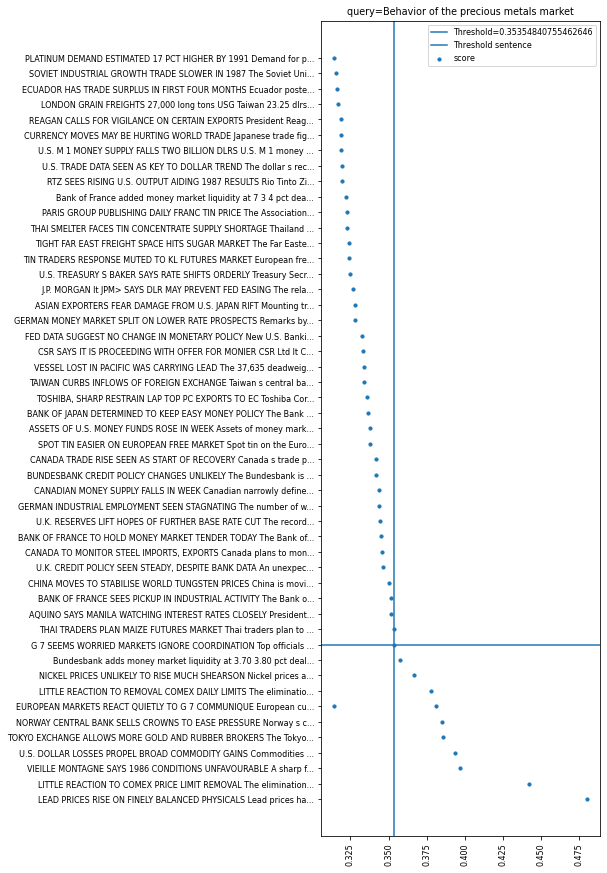

Selected texts for query " Behavior of the precious metals market ":

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

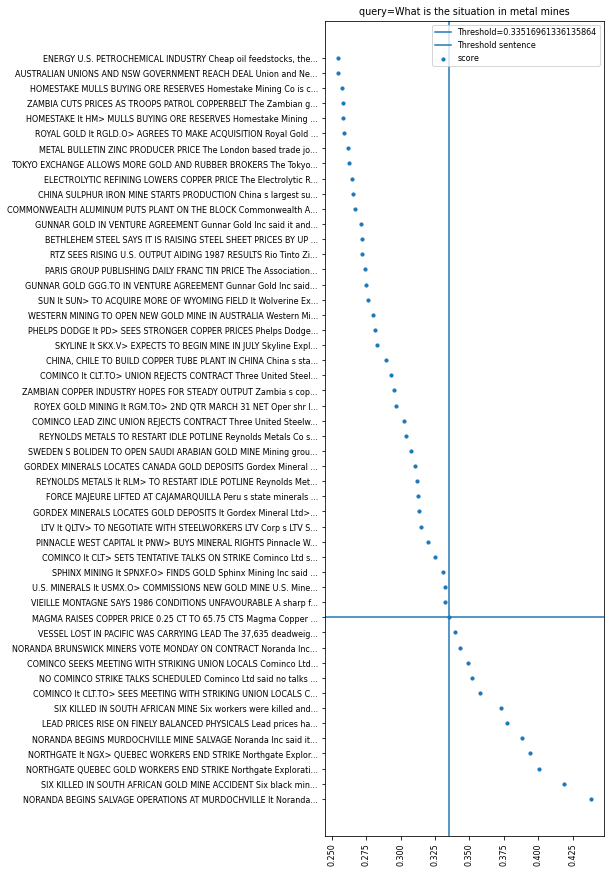

Selected texts for query " What is the situation in metal mines ":

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

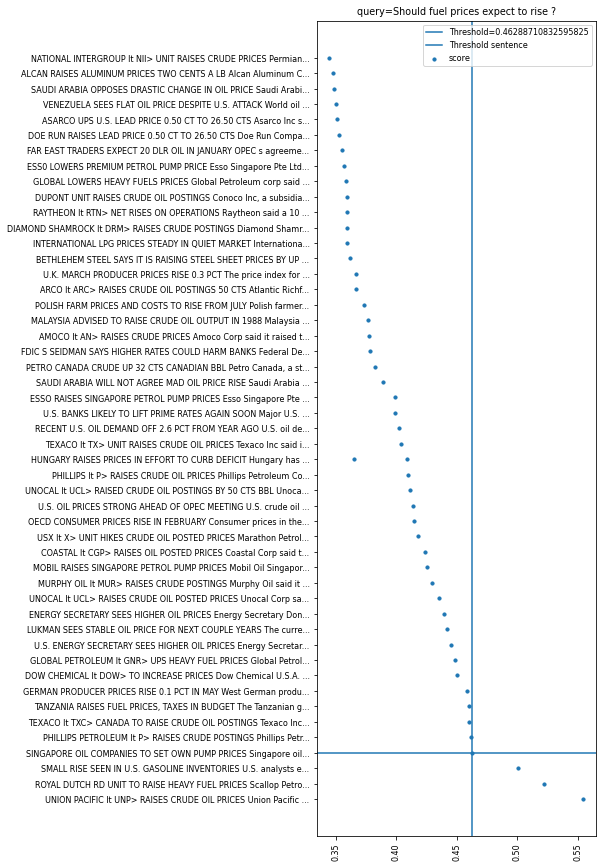

Selected texts for query " Should fuel prices expect to rise ? ":

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

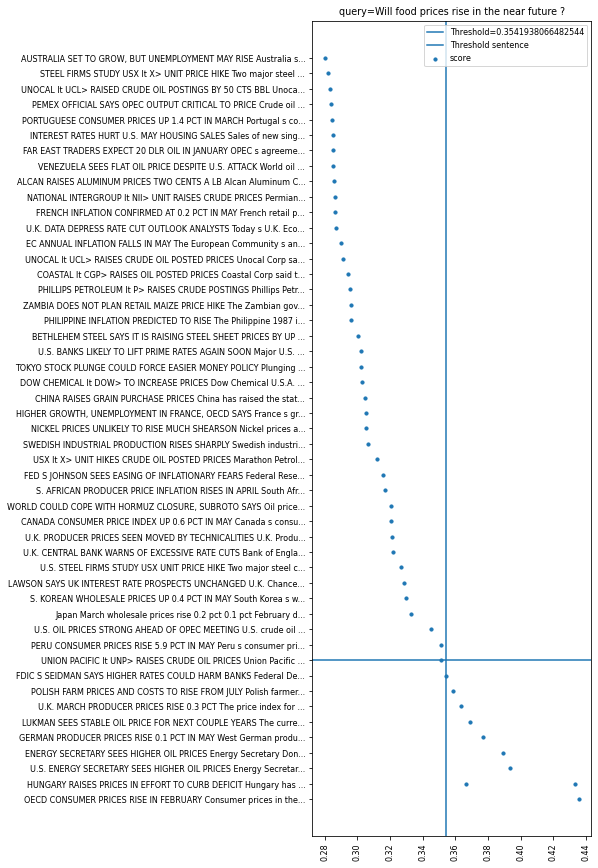

Selected texts for query " Will food prices rise in the near future ? ":

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

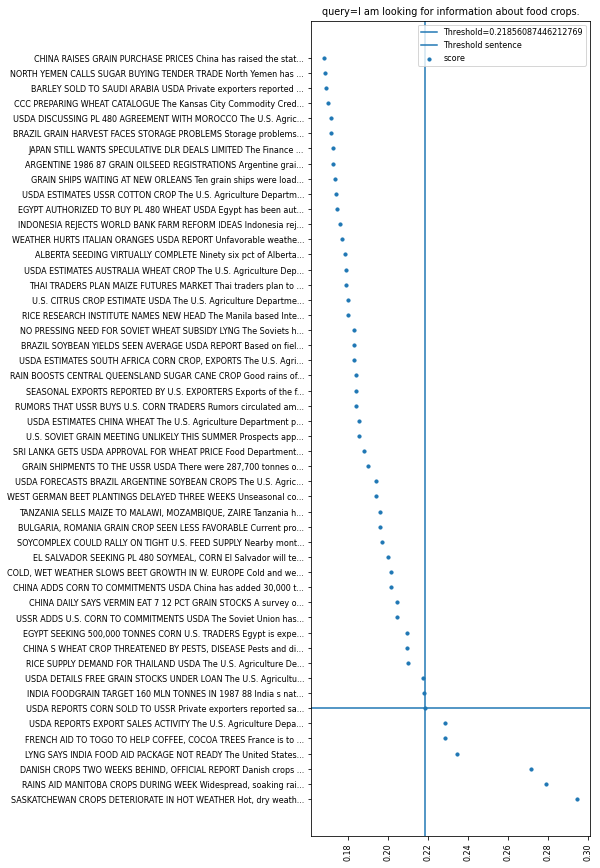

Selected texts for query " I am looking for information about food crops. ":

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

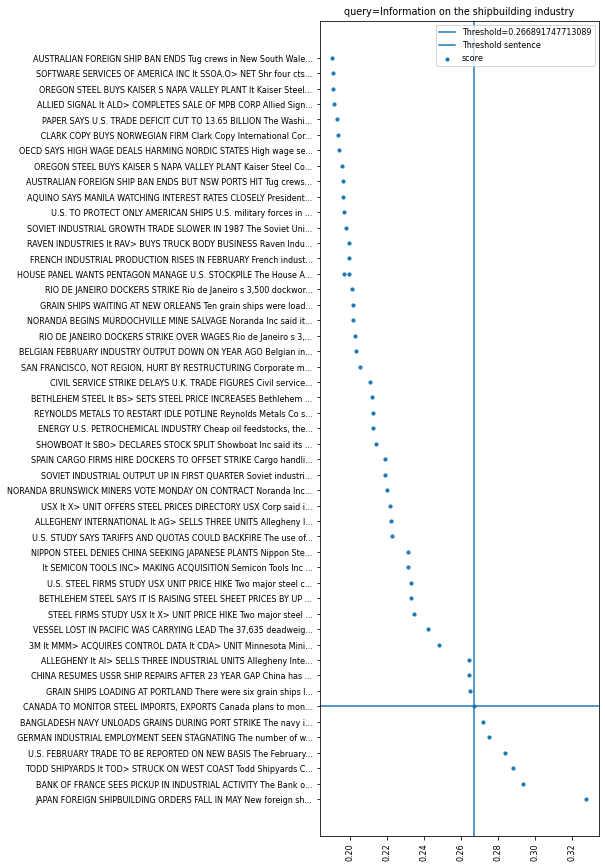

Selected texts for query " Information on the shipbuilding industry ":

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [17]:
matplotlib.rcParams.update({'font.size': 8})
query_list = []
matched_phrases_list = []
matched_phrases_scores_list = []
min_val_ = 0.
margin_ = 0.

if True:

    for query in result_df['query'].unique():
        min_ = result_df[(result_df['query'] == query)]['score'].min()
        max_ = result_df[(result_df['query'] == query)]['score'].max()
        std_ = result_df[(result_df['query'] == query)]['score'].std()
        
        if max_ > min_val_:
            print (query)
            sentences_ = result_df[(result_df['query'] == query)]['sentence'].values
            x = []
            for y_ in sentences_:
                x.append(y_[:60]+'...')
    
            y1 = result_df[(result_df['query'] == query)]['score'].values
    
            # determne elbow value:
            x0 = list(range(len(y1)))
            
            kn = KneeLocator(x0, y1, S=1., curve='convex', direction='decreasing') 
            elbow_1 = kn.knee
            print ('Elbow point values:\n tekst_id=', elbow_1, '; threshold value=',y1[elbow_1])
    
            df = pd.DataFrame()
            df['sentence'] = sentences_[:(elbow_1+1)]
            df['score'] = y1[:(elbow_1+1)]
        
            query_list.append(query)
            matched_phrases_list.append(sentences_[:(elbow_1+1)])
            matched_phrases_scores_list.append(y1[:(elbow_1+1)])
    
            plt.figure(figsize=(5,15))
            plt.scatter(y1,x,s=10,label='score')
            plt.axvline(y1[elbow_1],label='Threshold='+str(y1[elbow_1]))
            plt.axhline(elbow_1,label='Threshold sentence')
            plt.title('query='+query)
            plt.legend()
            plt.xticks(rotation=90)
            plt.show()
            print ('Selected texts for query \"', query,'\":\n')
            print (df)
            print ('=====================\n')
        else:
            pass
        
Selected_features = pd.DataFrame()
Selected_features['Query'] = query_list
Selected_features['Matches'] = matched_phrases_list
Selected_features['Matches_scores'] = matched_phrases_scores_list